In [2]:
import pandas as pd
import numpy as np

# Fungsi untuk menghitung PDF Gaussian
def gaussian_pdf(X, mean, cov):
    n = X.shape[1]
    diff = X - mean
    exp_term = np.exp(-0.5 * np.sum(np.dot(diff, np.linalg.inv(cov)) * diff, axis=1))
    return exp_term / np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))

# Fungsi untuk inisialisasi parameter GMM
def initialize_gmm(X, k):
    n, d = X.shape
    weights = np.ones(k) / k
    means = X[np.random.choice(n, k, replace=False)]
    covariances = np.array([np.cov(X, rowvar=False)] * k)
    return weights, means, covariances

# Membaca data dari file Excel
file_path = 'data.xlsx'  # Ganti dengan path file Excel Anda
df = pd.read_excel(file_path)

# Encoding categorical variables
df['Status Gizi Ibu'] = df['Status Gizi Ibu'].map({'Baik': 1, 'Kurang': 0})
df['Riwayat Penyakit'] = df['Riwayat Penyakit'].map({'Tidak Ada': 1, 'Ada': 0})
df['Kondisi Lingkungan'] = df['Kondisi Lingkungan'].map({'Baik': 2, 'Sedang': 1, 'Kurang': 0})
df['Akses Layanan Kesehatan'] = df['Akses Layanan Kesehatan'].map({'Baik': 2, 'Sedang': 1, 'Kurang': 0})

# Features for clustering
features = ['Usia (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)', 'Status Gizi Ibu', 'Riwayat Penyakit', 'Kondisi Lingkungan', 'Akses Layanan Kesehatan']
X = df[features].values

# Handling infinite values
X = np.nan_to_num(X)

# Standarisasi data
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Menentukan jumlah klaster
k = 6  # Sesuai dengan kategori tingkat gizi: Gizi Baik, Gizi Cukup, Gizi Buruk, Gizi Kurang, Gizi Berlebih, dan Obesitas

# Inisialisasi parameter GMM
weights, means, covariances = initialize_gmm(X, k)
print("Inisialisasi selesai")
print("Bobot Awal:", weights)
print("Mean Awal:", means)
print("Kovarians Awal:", covariances)


Inisialisasi selesai
Bobot Awal: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Mean Awal: [[-1.82352109e+00 -8.75764316e-01 -3.48192300e-01 -9.87873520e-01
   1.00380725e+00  1.17961771e-02  1.22606964e+00]
 [-1.69280506e-01  5.87811076e-01  2.94104123e-01 -9.87873520e-01
  -9.96207193e-01  1.24056463e+00  1.22606964e+00]
 [ 6.57839783e-01  2.99251704e+00  2.15992379e+00 -9.87873520e-01
  -9.96207193e-01  1.17961771e-02 -1.59596529e-03]
 [ 3.74995661e-02 -1.50758744e+00  2.93552503e-02  1.01227534e+00
  -9.96207193e-01 -1.21697227e+00 -1.22926157e+00]
 [-9.96400796e-01 -6.79893565e-01 -4.06131415e-01  1.01227534e+00
   1.00380725e+00  1.24056463e+00 -1.59596529e-03]
 [-1.82352109e+00  2.35293154e-01  7.38439866e-01 -9.87873520e-01
  -9.96207193e-01  1.17961771e-02 -1.59596529e-03]]
Kovarians Awal: [[[ 1.00010001e+00 -6.92123578e-03  2.50831786e-02 -8.12011266e-03
   -4.78522404e-03  8.07029728e-03  1.23985275e-02]
  [-6.92123578e-03  1.00010001e+00  2.68951076e-02

In [3]:
# Fungsi E-step
def e_step(X, weights, means, covariances):
    k = len(weights)
    n = X.shape[0]
    resp = np.zeros((n, k))

    for i in range(k):
        resp[:, i] = weights[i] * gaussian_pdf(X, means[i], covariances[i])
    
    resp /= resp.sum(axis=1, keepdims=True)
    return resp

# Melakukan E-step
resp = e_step(X, weights, means, covariances)
print("E-step selesai")
print("Responsibilitas:", resp)


E-step selesai
Responsibilitas: [[1.39509177e-03 2.60889911e-03 7.87770206e-06 3.48241035e-02
  9.59768888e-01 1.39513965e-03]
 [2.23577054e-03 2.54016164e-03 9.93352518e-06 1.34954223e-02
  9.78540234e-01 3.17847815e-03]
 [2.07965832e-02 2.70442225e-02 6.05289123e-07 1.22738027e-03
  9.50645469e-01 2.85739961e-04]
 ...
 [7.17569360e-01 2.38994777e-02 3.27193462e-04 1.21371201e-02
  4.62764048e-02 1.99790444e-01]
 [9.01551670e-04 8.90205790e-01 1.48597128e-02 2.61197108e-03
  2.30990987e-02 6.83218755e-02]
 [3.84378086e-02 9.08649189e-01 6.58303655e-06 5.20816047e-03
  2.69746709e-02 2.07235881e-02]]


In [4]:
# Fungsi M-step dengan regularisasi
def m_step(X, resp, epsilon=1e-6):
    n, d = X.shape
    k = resp.shape[1]
    
    weights = resp.sum(axis=0) / n
    means = np.dot(resp.T, X) / resp.sum(axis=0)[:, np.newaxis]
    covariances = np.zeros((k, d, d))
    
    for i in range(k):
        diff = X - means[i]
        covariances[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
        # Menambahkan regularisasi ke diagonal kovarians
        covariances[i] += np.eye(d) * epsilon
    
    return weights, means, covariances

# Melakukan M-step dengan regularisasi
weights, means, covariances = m_step(X, resp)
print("M-step selesai")
print("Bobot Baru:", weights)
print("Mean Baru:", means)
print("Kovarians Baru:", covariances)


M-step selesai
Bobot Baru: [0.12043385 0.22316937 0.0412707  0.21065451 0.24992003 0.15455153]
Mean Baru: [[-0.46964353 -0.33001535 -0.23374464 -0.60336719  0.74496552 -0.35095196
   0.57527347]
 [ 0.38110441  0.31921633 -0.00179119 -0.40774731 -0.43161259  0.48732589
   0.53164647]
 [ 0.71528049  1.45827698  0.93015312 -0.24073977 -0.0919145  -0.27450392
  -0.24588993]
 [ 0.37288135 -0.4763008  -0.04992387  0.45912874 -0.37447725 -0.68111038
  -0.5438046 ]
 [-0.11658093 -0.10671131 -0.21193925  0.60809247  0.64383506  0.50257271
  -0.11410295]
 [-0.69506401  0.22856977  0.34711392 -0.48588315 -0.46343726 -0.24124484
  -0.22458565]]
Kovarians Baru: [[[ 7.32037095e-01 -4.93372368e-02  3.92178683e-02 -8.36185377e-02
    7.62799648e-02 -5.74215827e-02  4.08471863e-02]
  [-4.93372368e-02  8.39479347e-01 -7.28802510e-02  5.67536996e-02
    8.20458675e-02 -6.77472029e-02 -1.86894471e-02]
  [ 3.92178683e-02 -7.28802510e-02  9.05026189e-01  2.94201595e-02
    7.56070847e-02 -8.35238984e-04  5.

In [5]:
# Fungsi log-likelihood
def log_likelihood(X, weights, means, covariances):
    k = len(weights)
    n = X.shape[0]
    log_likelihood = 0
    
    for i in range(n):
        tmp = 0
        for j in range(k):
            tmp += weights[j] * gaussian_pdf(X[i].reshape(1, -1), means[j], covariances[j])
        log_likelihood += np.log(tmp)
    
    return log_likelihood

# Menghitung log-likelihood
current_log_likelihood = log_likelihood(X, weights, means, covariances)
print("Log Likelihood:", current_log_likelihood)


Log Likelihood: [-98717.91491369]


In [6]:
# Fungsi untuk GMM dengan pengecekan NaN dan regularisasi
def gmm(X, k, tol=1e-6, nan_threshold=5):
    weights, means, covariances = initialize_gmm(X, k)
    log_likelihoods = []
    nan_count = 0
    iteration = 0
    
    while True:
        iteration += 1
        print(f"Iteration {iteration}")
        resp = e_step(X, weights, means, covariances)
        weights, means, covariances = m_step(X, resp)
        current_log_likelihood = log_likelihood(X, weights, means, covariances)
        
        if np.isnan(current_log_likelihood):
            nan_count += 1
            print(f"Log Likelihood is NaN. NaN count: {nan_count}")
        else:
            nan_count = 0
            log_likelihoods.append(current_log_likelihood)
            print(f"Log Likelihood: {current_log_likelihood}")
        
        if nan_count >= nan_threshold:
            print("Terminating due to repeated NaN log likelihoods.")
            break
        
        if iteration > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print("Converged")
            break
    
    return weights, means, covariances, resp, log_likelihoods

# Melakukan GMM
weights, means, covariances, resp, log_likelihoods = gmm(X, k)

# Menentukan klaster untuk setiap data
clusters = resp.argmax(axis=1)

# Menambahkan hasil klaster ke DataFrame
df['Cluster'] = clusters

# Menyimpan hasil ke dalam file Excel
output_excel_path = 'clustered_data_manual.xlsx'
df.to_excel(output_excel_path, index=False)


Iteration 1
Log Likelihood: [-99083.22191045]
Iteration 2
Log Likelihood: [-98755.15856944]
Iteration 3
Log Likelihood: [-97564.37449725]
Iteration 4
Log Likelihood: [-79358.38702294]
Iteration 5
Log Likelihood: [-60248.24819643]
Iteration 6
Log Likelihood: [-33531.2335219]
Iteration 7
Log Likelihood: [-27707.29104689]
Iteration 8
Log Likelihood: [-12085.35653061]
Iteration 9
Log Likelihood: [-3157.61876134]
Iteration 10
Log Likelihood: [8758.16961624]
Iteration 11
Log Likelihood: [8802.06661871]
Iteration 12
Log Likelihood: [8935.92912682]
Iteration 13
Log Likelihood: [9646.44276185]
Iteration 14
Log Likelihood: [10814.24808289]
Iteration 15
Log Likelihood: [10828.16500391]
Iteration 16
Log Likelihood: [10839.18421846]
Iteration 17
Log Likelihood: [10848.9807094]
Iteration 18
Log Likelihood: [10858.88677212]
Iteration 19
Log Likelihood: [10870.37046417]
Iteration 20
Log Likelihood: [10885.94357237]
Iteration 21
Log Likelihood: [10911.87467576]
Iteration 22
Log Likelihood: [10971.74008

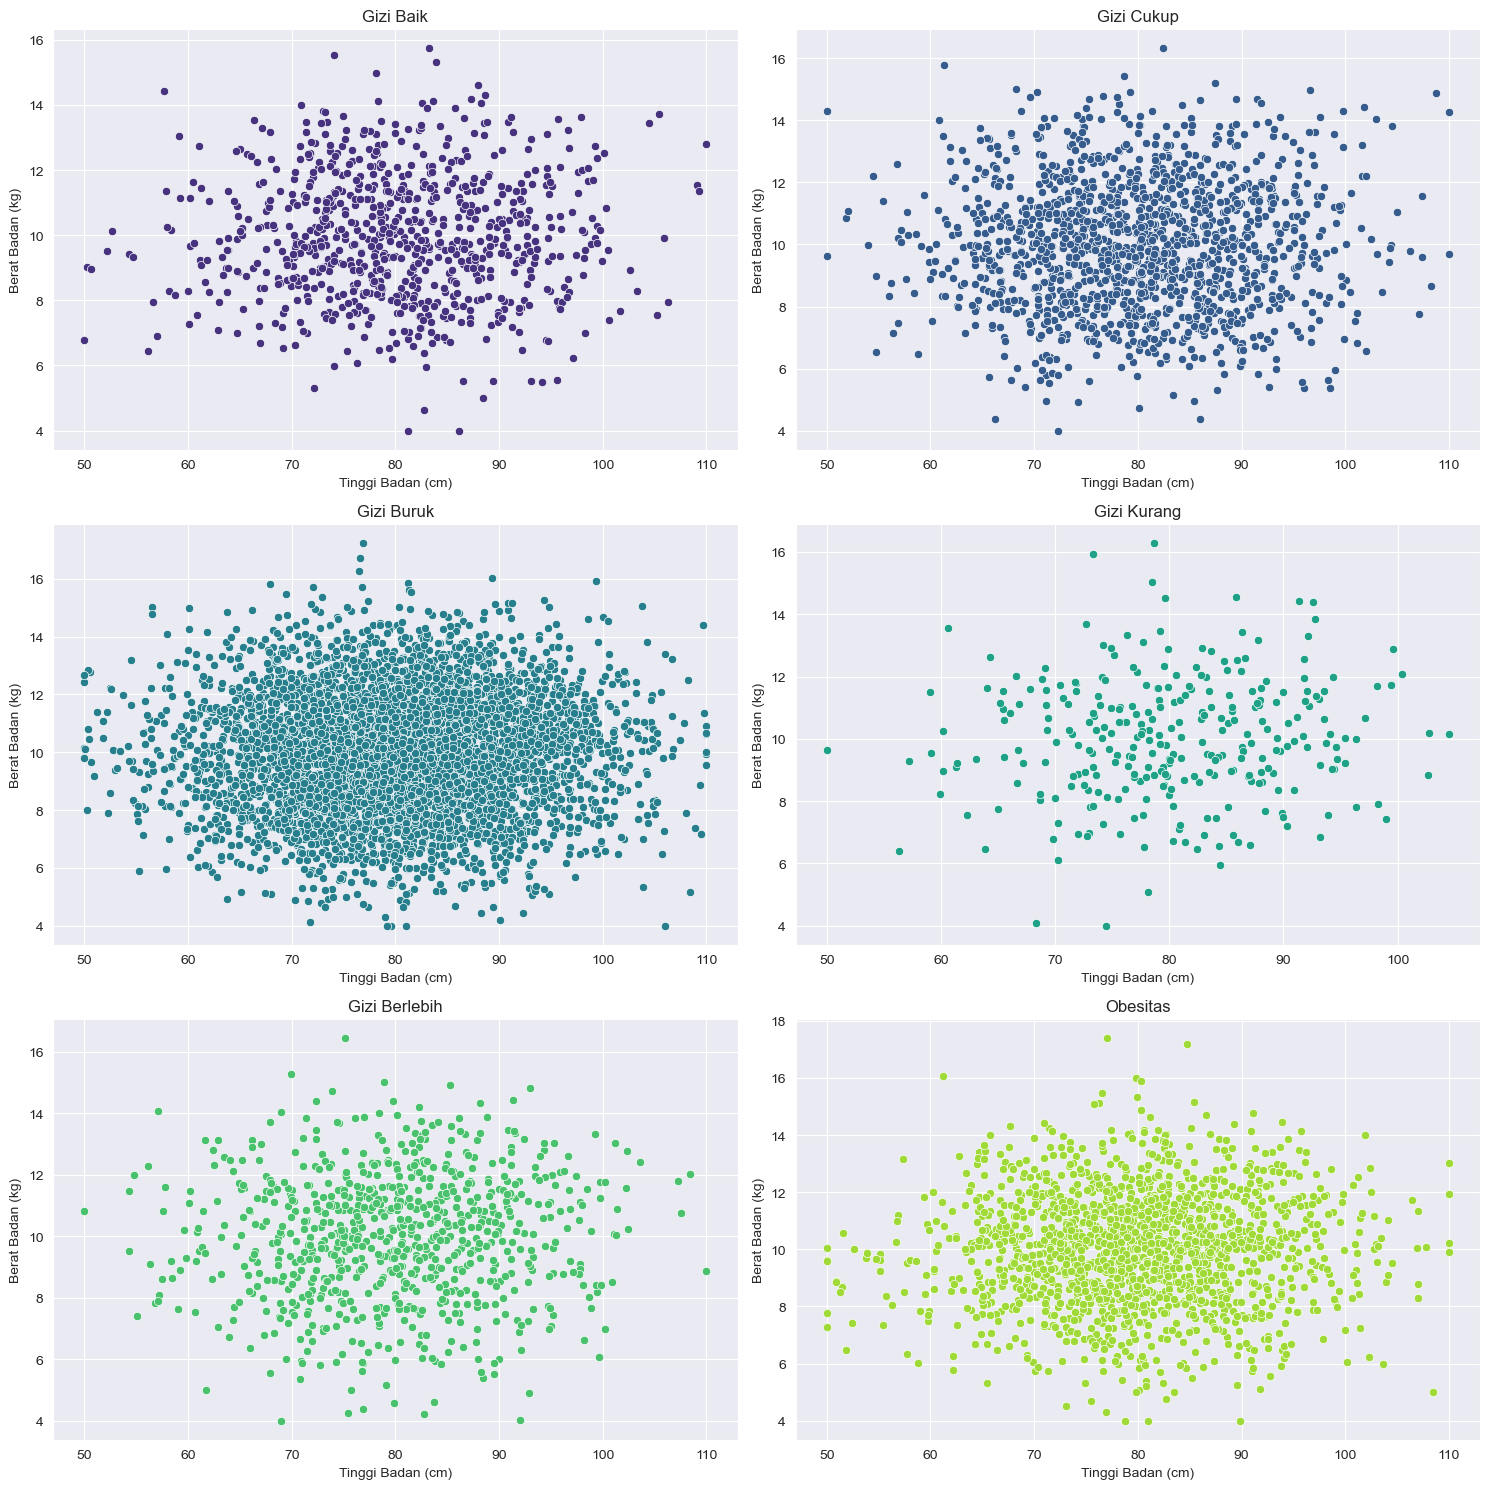

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping kluster ke label tingkat gizi
cluster_labels = {
    0: 'Gizi Baik',
    1: 'Gizi Cukup',
    2: 'Gizi Buruk',
    3: 'Gizi Kurang',
    4: 'Gizi Berlebih',
    5: 'Obesitas'
}

df['Cluster Label'] = df['Cluster'].map(cluster_labels)

# Menentukan palet warna untuk setiap klaster
palette = sns.color_palette("viridis", n_colors=len(cluster_labels))

# Plotting the clusters in a 3x2 grid dengan warna berbeda
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, (cluster, label) in enumerate(cluster_labels.items()):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(data=df[df['Cluster'] == cluster], x='Tinggi Badan (cm)', y='Berat Badan (kg)', ax=ax, color=palette[i])
    ax.set_title(label)
    ax.set_xlabel('Tinggi Badan (cm)')
    ax.set_ylabel('Berat Badan (kg)')

plt.tight_layout()
plot_grid_path = 'clustered_data_plot_grid.png'
plt.savefig(plot_grid_path)
plt.show()
plt.close()




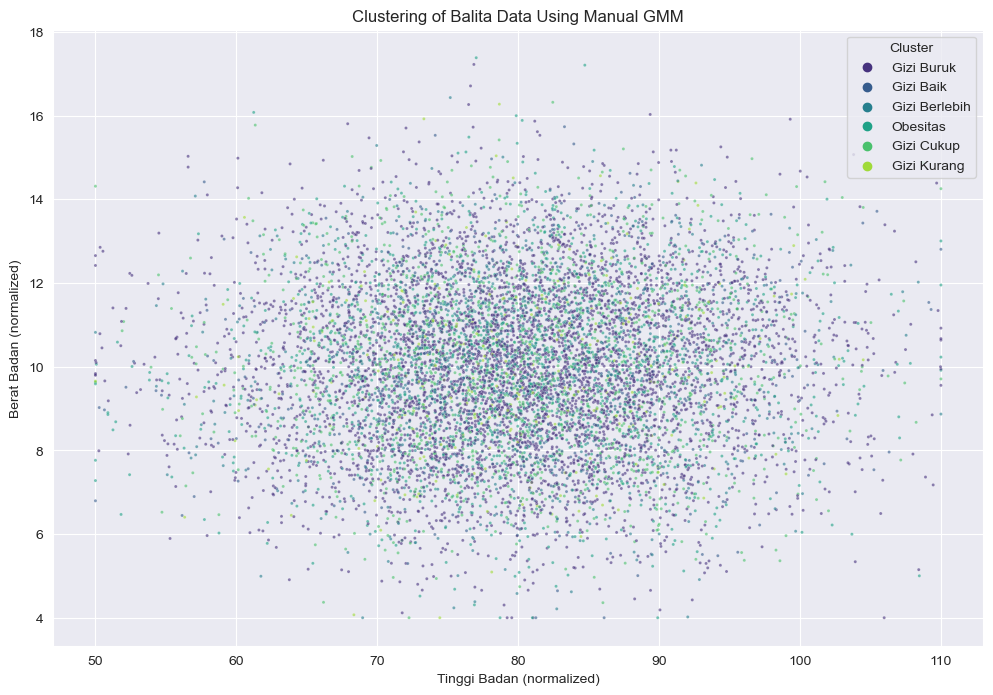

In [9]:
# Plotting the overall clusters dengan warna berbeda
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Tinggi Badan (cm)', y='Berat Badan (kg)', hue='Cluster Label', palette=palette, s=5, alpha=0.6)
plt.title('Clustering of Balita Data Using Manual GMM')
plt.xlabel('Tinggi Badan (normalized)')
plt.ylabel('Berat Badan (normalized)')
plt.legend(title='Cluster')
overall_plot_path = 'clustered_data_plot_manual.png'
plt.savefig(overall_plot_path)
plt.show()
plt.close()